In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
from astra.torch.models import EfficientNet,ResNetClassifier, MLP, MLPClassifier, EfficientNetClassifier
from astra.torch.utils import count_params
print(count_params(EfficientNetClassifier()))
print(count_params(ResNetClassifier()))

{'total_params': 4664446, 'trainable_params': 4664446, 'non_trainable_params': 0}
{'total_params': 11440194, 'trainable_params': 11440194, 'non_trainable_params': 0}


In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torch.nn as nn
import copy
import time
import os
import argparse
from torch.utils.data import Subset
import csv
device = torch.device('cuda')
from ResNet import *
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score,precision_score,recall_score
from sklearn.metrics import ConfusionMatrixDisplay

### transforms for downstream tasks

In [5]:
# transform_test = transforms.Compose([
#         transforms.Resize(224),
#         # transforms.ToTensor(),
#         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
#     ])

# transform_eval = transforms.Compose([
#         transforms.RandomResizedCrop((224,224), scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)),
#         transforms.RandomHorizontalFlip(p=0.5),
#         transforms.Resize(224),
#         # transforms.ToTensor(),
#         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
#     ])


In [6]:
loaded_data = torch.load("/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/tensor_data/test_data.pt")
loaded_data1 = torch.load("/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/tensor_data/data.pt")
images= loaded_data1['images']
labels = loaded_data1['labels']
images = images / 255
images = (images - images.mean(dim=(0, 2, 3), keepdim=True)) / images.std(dim=(0, 2, 3), keepdim=True)
images1 = loaded_data['images']
labels1 = loaded_data['labels']
images1 = images1 / 255
images1 = (images1 - images1.mean(dim=(0, 2, 3), keepdim=True)) / images1.std(dim=(0, 2, 3), keepdim=True)
print(images1.shape)
print(labels1.shape)
print(images.shape)
print(labels.shape)
train_images = images
train_labels = labels
test_images = images1
test_labels = labels1

torch.Size([10025, 3, 224, 224])
torch.Size([10025])
torch.Size([25500, 3, 224, 224])
torch.Size([25500])


In [7]:
train_labels_count = (train_labels == 1).sum()
test_labels_count = (test_labels == 1).sum()

print("Number of train labels with value 1:", train_labels_count)
print("Number of test labels with value 1:", test_labels_count)
# train_images=transform_eval(train_images)
# test_images=transform_test(test_images)

Number of train labels with value 1: tensor(1697)
Number of test labels with value 1: tensor(1042)


### Data preporcessing for how much percentage of the data is used for finetune

In [8]:
print(train_images.shape)
print(test_images.shape)
train_set=torch.utils.data.TensorDataset(train_images,train_labels)
test_set=torch.utils.data.TensorDataset(test_images,test_labels)
train_loader=torch.utils.data.DataLoader(train_set,batch_size=512,shuffle=True,num_workers=8)
test_loader=torch.utils.data.DataLoader(test_set,batch_size=512,shuffle=False,num_workers=8)

torch.Size([25500, 3, 224, 224])
torch.Size([10025, 3, 224, 224])


In [9]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x
class SimCLR_model(nn.Module):
    def __init__(self, base_encoder, projection_dim, n_features):
        super(SimCLR_model, self).__init__()

        self.base_encoder = base_encoder
        self.n_features = n_features
        self.base_encoder.fc=nn.Linear(n_features, n_features)

        self.base_encoder.linear = Identity()
        self.projectionHead = nn.Sequential(
            nn.Linear(self.n_features, self.n_features, bias=False),
            nn.BatchNorm1d(self.n_features),
            nn.ReLU(), #non-linearity
            nn.Linear(self.n_features, projection_dim, bias=False),
            nn.BatchNorm1d(projection_dim),
        )

    def forward(self, x_i, x_j):
        h_i = self.base_encoder(x_i)
        h_j = self.base_encoder(x_j)
        
        z_i = self.projectionHead(h_i)
        z_j = self.projectionHead(h_j)
        
        return h_i, h_j, z_i, z_j

In [10]:
base_encoder = ResNet50()
projection_dim=224
n_features= base_encoder.fc.in_features
net= SimCLR_model(base_encoder, projection_dim, n_features)
# net= net.to(device)
# net
print(base_encoder.fc.weight) #weights of the linear layer before loading the model with SimCLR

# path_paramsend = "/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/Saved_model/paramsend_bs_restart_r_bk_1.pt"
# checkpoint = torch.load(path_paramsend, map_location=torch.device('cpu'))
# loss= checkpoint['loss']
# epoch = checkpoint['epoch']
start_epoch=0
# net.load_state_dict(checkpoint['net'])
# epoch

Parameter containing:
tensor([[-0.0154, -0.0049, -0.0029,  ...,  0.0210,  0.0038, -0.0135],
        [-0.0137, -0.0174,  0.0102,  ...,  0.0083, -0.0198,  0.0178],
        [ 0.0007,  0.0117, -0.0174,  ..., -0.0095, -0.0061, -0.0152],
        ...,
        [-0.0077, -0.0165,  0.0011,  ...,  0.0177,  0.0159,  0.0079],
        [ 0.0023,  0.0152,  0.0165,  ..., -0.0099,  0.0071, -0.0141],
        [ 0.0165, -0.0158, -0.0012,  ...,  0.0107,  0.0055,  0.0218]],
       requires_grad=True)


In [11]:
classes = ('positive', 'negetive')
net_eval= base_encoder
n_features= base_encoder.fc.in_features
print(n_features)
net_eval.linear=nn.Linear(n_features, len(classes)) 
print(net_eval.linear)
optimizer= torch.optim.Adam(net_eval.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
net_eval.to(device)
print(net_eval.fc.weight) #weights of the linear layer after loading the model with SimCLR

2048
Linear(in_features=2048, out_features=2, bias=True)
Parameter containing:
tensor([[-0.0154, -0.0049, -0.0029,  ...,  0.0210,  0.0038, -0.0135],
        [-0.0137, -0.0174,  0.0102,  ...,  0.0083, -0.0198,  0.0178],
        [ 0.0007,  0.0117, -0.0174,  ..., -0.0095, -0.0061, -0.0152],
        ...,
        [-0.0077, -0.0165,  0.0011,  ...,  0.0177,  0.0159,  0.0079],
        [ 0.0023,  0.0152,  0.0165,  ..., -0.0099,  0.0071, -0.0141],
        [ 0.0165, -0.0158, -0.0012,  ...,  0.0107,  0.0055,  0.0218]],
       device='cuda:0', requires_grad=True)


In [12]:
net_eval

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchN

### fine-tune the downstram model  and predict on test data

In [13]:
#train net_eval
net_eval.train()
for epoch in range(start_epoch, start_epoch+50):
    # print('Epoch: %d' % epoch)
    net_eval.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net_eval(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    if (epoch+1)%10==0:
        print('Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)'
            % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))



Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Train Loss: 0.067 | Train Acc: 97.894% (24963/25500)
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Train Loss: 0.046 | Train Acc: 98.412% (25095/25500)
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Train Loss: 0.028 | Train Acc: 99.004% (25246/25500)
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Train Loss: 0.032 | Train Acc: 98.949% (25232/25500)
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Train Loss: 0.004 | Train Acc: 99.890% (25472/25500)


In [14]:
result_dict = {}


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

percent = "1%"
ssl = "No_SimCLR"
with torch.no_grad():    
    net_eval.eval()
    correct = 0
    total = 0
    y_pred = []
    y_test = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net_eval(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            y_pred.extend(predicted.cpu().numpy())
            y_test.extend(targets.cpu().numpy())
    
    y_pred = np.array(y_pred)
    y_test = np.array(y_test)
    
    print('Test Acc: %.3f%% (%d/%d)' % (100.*correct/total, correct, total))
    print(len(y_pred), len(y_test))
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 Score: ", f1)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    # If needed, class-specific metrics
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    class_precision = precision_score(y_test, y_pred, average=None)
    class_recall = recall_score(y_test, y_pred, average=None)
    class_f1 = f1_score(y_test, y_pred, average=None)

    print("Class-specific Accuracy:", class_accuracy)
    print("Class-specific Precision:", class_precision)
    print("Class-specific Recall:", class_recall)
    print("Class-specific F1 Score:", class_f1)
    result_dict[f"{percent} {ssl}"] = {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}
    print(result_dict)

Test Acc: 89.796% (9002/10025)
10025 10025
Accuracy:  0.8979551122194513
Precision:  0.6610169491525424
Recall:  0.03742802303262956
F1 Score:  0.07084468664850135
Confusion Matrix:
[[8963   20]
 [1003   39]]
Class-specific Accuracy: [0.99777357 0.03742802]
Class-specific Precision: [0.89935782 0.66101695]
Class-specific Recall: [0.99777357 0.03742802]
Class-specific F1 Score: [0.94601298 0.07084469]
{'1% No_SimCLR': {'accuracy': 0.8979551122194513, 'f1': 0.07084468664850135, 'precision': 0.6610169491525424, 'recall': 0.03742802303262956}}


In [14]:
print(result_dict)

{'1% No_SimCLR': {'accuracy': 0.8960598503740649, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0}}


In [15]:
import pickle

# Specify the file path
file_path = "dictionary1%_NoSSL.pkl"

# Open the file in write mode
with open(file_path, "wb") as file:
    # Write the dictionary to the file
    pickle.dump(result_dict, file)


In [16]:
# y_pred,ytest=prdict(net_eval, test_loader, "30%", "No_ssl", device,)

In [17]:
print(result_dict)

{'1% No_SimCLR': {'accuracy': 0.8960598503740649, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0}}


In [18]:
# import pickle

# file_path = "dictionary30%_nossl.pkl"

# # Open the file in write mode
# with open(file_path, "wb") as file:
#     # Write the dictionary to the file
#     pickle.dump(result_dict, file)

In [19]:
# # Load the dictionaries from the files
with open("merged_dictionary_main.pkl", "rb") as file1, open("dictionary1%_NoSSL.pkl", "rb") as file2:
    dict1 = pickle.load(file1)
    dict2 = pickle.load(file2)

# Merge the dictionaries
merged_dict = {**dict1, **dict2}

# Save the merged dictionary to a file
with open("merged_dictionary_main.pkl", "wb") as file:
    pickle.dump(merged_dict, file)

In [20]:
# Load the merged dictionary from the file
with open("merged_dictionary_main.pkl", "rb") as file:
    merged_dict = pickle.load(file)

# Print the merged dictionary
print(merged_dict)

{'10% SimCLR': {'accuracy': 0.8674314214463841, 'f1': 0.21221102548903378, 'precision': 0.2775193798449612, 'recall': 0.17178502879078694}, '30% SimCLR': {'accuracy': 0.8766084788029925, 'f1': 0.3177054605626034, 'precision': 0.3735408560311284, 'recall': 0.2763915547024952}, '50% SimCLR': {'accuracy': 0.8941645885286783, 'f1': 0.3454657618753856, 'precision': 0.4835924006908463, 'recall': 0.2687140115163148}, '100% SimCLR': {'accuracy': 0.9054364089775561, 'f1': 0.2914798206278027, 'precision': 0.6587837837837838, 'recall': 0.1871401151631478}, '100% No_SimCLR': {'accuracy': 0.8944638403990025, 'f1': 0.3111979166666667, 'precision': 0.48380566801619435, 'recall': 0.22936660268714013}, '50% No_SimCLR': {'accuracy': 0.8751122194513715, 'f1': 0.29105322763306907, 'precision': 0.35497237569060774, 'recall': 0.24664107485604606}, '30% No_SimCLR': {'accuracy': 0.8785037406483791, 'f1': 0.4023552502453385, 'precision': 0.41164658634538154, 'recall': 0.3934740882917466}, '10% No_SimCLR': {'ac

In [21]:
import pandas as pd

In [22]:
resdf = pd.DataFrame(merged_dict)
resdf

,10% SimCLR,30% SimCLR,50% SimCLR,100% SimCLR,100% No_SimCLR,50% No_SimCLR,30% No_SimCLR,10% No_SimCLR,1% No_SimCLR
accuracy,0.867431,0.876608,0.894165,0.905436,0.894464,0.875112,0.878504,0.859751,0.89606
f1,0.212211,0.317705,0.345466,0.291480,0.311198,0.291053,0.402355,0.264644,0.00000
precision,0.277519,0.373541,0.483592,0.658784,0.483806,0.354972,0.411647,0.290805,0.00000
recall,0.171785,0.276392,0.268714,0.187140,0.229367,0.246641,0.393474,0.242802,0.00000


In [23]:
# result_df = pd.DataFrame(result_dict)
# result_df.to_csv('SSL_Result.csv', index=False)

# df=pd.read_csv("/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/SSL_Experiments/patchfill_experiments/SSL_Result.csv")
# df


In [24]:
#list to tensor
y_pred = torch.tensor(y_pred)
ytest = torch.tensor(y_test)
def results(y_labels,y_pred,plot_confusion = False):
    y_labels = y_labels.to(device) 
    y_pred = y_pred.to(device)
    print(f"Accuracy = {(y_labels == y_pred).float().mean()}")
    if plot_confusion:
        cm = confusion_matrix(y_labels.cpu(), y_pred.cpu())
        unique_labels = np.unique(y_labels.cpu())
        cm_display = ConfusionMatrixDisplay(cm, display_labels=unique_labels).plot(values_format='d', cmap='Blues')
        plt.show()

Accuracy = 0.8960598111152649


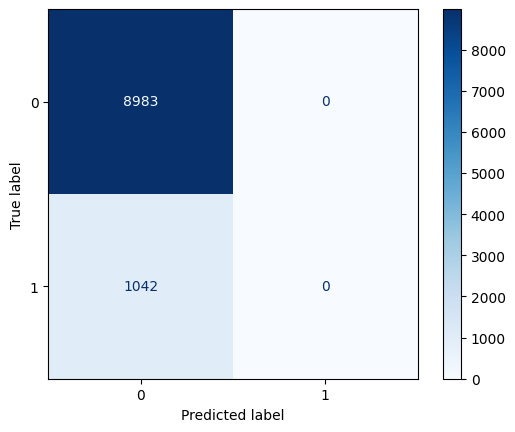

: 

In [25]:
results(ytest,y_pred,plot_confusion = True)